In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

c:\Users\lalo8\OneDrive\GitHub\nfl_ml_project\venv_nfl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I just realize that we have prea aggregated weekly data, so we are going to explor it and try o build a first baseline model that we are going to improve later..

In [3]:
# download the data from kaggle
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

In [4]:
# Load the CSV file into a DataFrame
# [weekly_player_stats_defense.csv'', 'weekly_player_stats_offense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv', 'yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'yearly_team_stats_offense.csv']
weekly_df_defense_team = pd.read_csv(os.path.join(dataset_path, 'weekly_team_stats_defense.csv'))

In [6]:
num_columns = weekly_df_defense_team.shape[1]
num_rows = weekly_df_defense_team.shape[0]
column_names = weekly_df_defense_team.columns.tolist()

print(f"The dataset has {num_columns} columns and {num_rows} rows")

for col in column_names:
    null_count = weekly_df_defense_team[col].isnull().sum()  # Count null values
    print(f"Column: {col}, "
          f"Type: {weekly_df_defense_team[col].dtype}, "
          f"Unique Values: {weekly_df_defense_team[col].nunique()}, "
          f"Null Values: {null_count} ({null_count/num_rows:.1%})")

The dataset has 65 columns and 7088 rows
Column: game_id, Type: object, Unique Values: 3544, Null Values: 0 (0.0%)
Column: season, Type: int64, Unique Values: 13, Null Values: 0 (0.0%)
Column: week, Type: int64, Unique Values: 22, Null Values: 0 (0.0%)
Column: team, Type: object, Unique Values: 32, Null Values: 0 (0.0%)
Column: season_type, Type: object, Unique Values: 2, Null Values: 0 (0.0%)
Column: safety, Type: int64, Unique Values: 3, Null Values: 0 (0.0%)
Column: interception, Type: int64, Unique Values: 7, Null Values: 0 (0.0%)
Column: fumble, Type: int64, Unique Values: 8, Null Values: 0 (0.0%)
Column: fumble_lost, Type: int64, Unique Values: 6, Null Values: 0 (0.0%)
Column: fumble_forced, Type: int64, Unique Values: 7, Null Values: 0 (0.0%)
Column: fumble_not_forced, Type: int64, Unique Values: 6, Null Values: 0 (0.0%)
Column: fumble_out_of_bounds, Type: int64, Unique Values: 5, Null Values: 0 (0.0%)
Column: solo_tackle, Type: int64, Unique Values: 56, Null Values: 0 (0.0%)
Co

In [7]:
weekly_df_defense_team.head()

,game_id,season,week,team,season_type,safety,interception,fumble,fumble_lost,fumble_forced,...,average_solo_tackle,average_assist_tackle,average_tackle_with_assist,average_sack,average_qb_hit,average_def_touchdown,average_defensive_two_point_attempt,average_defensive_two_point_conv,average_defensive_extra_point_attempt,average_defensive_extra_point_conv
0,2012_01_SEA_ARI,2012,1,ARI,REG,0,1,2,1,1,...,55.000000,6.0,4.000000,3.0,8.000000,0.000000,0.0,0.0,0,0
1,2012_02_ARI_NE,2012,2,ARI,REG,0,1,0,0,0,...,51.000000,7.0,2.000000,3.5,7.000000,0.000000,0.0,0.0,0,0
2,2012_03_PHI_ARI,2012,3,ARI,REG,0,0,2,2,2,...,49.333333,6.0,1.666667,4.0,9.333333,0.333333,0.0,0.0,0,0
3,2012_04_MIA_ARI,2012,4,ARI,REG,0,2,4,2,3,...,50.500000,6.5,2.500000,4.0,9.500000,0.250000,0.0,0.0,0,0
4,2012_05_ARI_STL,2012,5,ARI,REG,0,1,0,0,0,...,47.400000,6.2,2.000000,3.4,8.800000,0.200000,0.0,0.0,0,0


In [8]:
weekly_df_defense_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7088 entries, 0 to 7087
Data columns (total 65 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   game_id                                7088 non-null   object 
 1   season                                 7088 non-null   int64  
 2   week                                   7088 non-null   int64  
 3   team                                   7088 non-null   object 
 4   season_type                            7088 non-null   object 
 5   safety                                 7088 non-null   int64  
 6   interception                           7088 non-null   int64  
 7   fumble                                 7088 non-null   int64  
 8   fumble_lost                            7088 non-null   int64  
 9   fumble_forced                          7088 non-null   int64  
 10  fumble_not_forced                      7088 non-null   int64  
 11  fumb

We have about 7k rows, and multiple seasons, so as we did with the previous dataset we are going to first decrease the ammount of rows. Tough I am curious how many rows per game we have.

In [9]:
# Confirm shape
print("Dataset Shape:", weekly_df_defense_team.shape)

# Check missing values
print("\nMissing Values:\n", weekly_df_defense_team.isnull().sum()[weekly_df_defense_team.isnull().sum() > 0])

# Display key columns
print("\nKey Columns:\n", weekly_df_defense_team[['solo_tackle', 'assist_tackle', 'tackle_with_assist', 
                              'average_solo_tackle', 'average_assist_tackle', 
                              'average_tackle_with_assist']].describe())

Dataset Shape: (7088, 65)

Missing Values:
 total_off_points    58
total_def_points    58
dtype: int64

Key Columns:
        solo_tackle  assist_tackle  tackle_with_assist  average_solo_tackle  \
count  7088.000000    7088.000000         7088.000000          7088.000000   
mean     39.291337      12.132054            4.283437            39.454111   
std       7.580297       5.659453            4.861502             4.237502   
min      13.000000       0.000000            0.000000            22.000000   
25%      34.000000       8.000000            0.000000            36.682292   
50%      39.000000      12.000000            3.000000            39.250000   
75%      44.000000      16.000000            7.000000            42.000000   
max      73.000000      41.000000           37.000000            61.000000   

       average_assist_tackle  average_tackle_with_assist  
count            7088.000000                 7088.000000  
mean               11.964636                    4.313869  
st

In [10]:
num_seasons = weekly_df_defense_team['season'].nunique()
seasons = weekly_df_defense_team['season'].unique()
print("Number of Seasons:", num_seasons)
print("Seasons Covered:", sorted(seasons))

Number of Seasons: 13
Seasons Covered: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [11]:
obs_per_game = weekly_df_defense_team.groupby('game_id').size()
print("Observations per Game:\n", obs_per_game.value_counts())

Observations per Game:
 2    3544
Name: count, dtype: int64


In [12]:
games_by_season = weekly_df_defense_team.groupby('season')['game_id'].nunique()
print("\nGames per Season:\n", games_by_season)

weeks_by_season = weekly_df_defense_team.groupby(['season', 'week'])['game_id'].nunique()
print("\nGames per Season and Week:\n", weeks_by_season)


Games per Season:
 season
2012    267
2013    267
2014    267
2015    267
2016    267
2017    267
2018    267
2019    267
2020    269
2021    285
2022    284
2023    285
2024    285
Name: game_id, dtype: int64

Games per Season and Week:
 season  week
2012    1       16
        2       16
        3       16
        4       15
        5       14
                ..
2024    18      16
        19       6
        20       4
        21       2
        22       1
Name: game_id, Length: 277, dtype: int64


Let's starting focus on only one season. 

In [14]:
wdf_def_2024 = weekly_df_defense_team[
    (weekly_df_defense_team['season'].isin([2024]))]

In [35]:
tackle_cols = ['solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack']
print("\nTackle Stats:\n", wdf_def_2024[tackle_cols].describe())

# Check for zeros or outliers
print("\nZero Tackle Games:\n", (wdf_def_2024[tackle_cols] == 0).sum())


Tackle Stats:
        solo_tackle  assist_tackle  tackle_with_assist        sack
count   570.000000     570.000000          570.000000  570.000000
mean     35.392982      15.270175            4.512281    2.442105
std       6.168685       4.383704            3.122123    1.805376
min      15.000000       5.000000            0.000000    0.000000
25%      32.000000      12.000000            2.000000    1.000000
50%      35.000000      15.000000            4.000000    2.000000
75%      39.000000      18.000000            6.000000    3.000000
max      55.000000      31.000000           18.000000    9.000000

Zero Tackle Games:
 solo_tackle            0
assist_tackle          0
tackle_with_assist    25
sack                  73
dtype: int64


In [36]:
num_teams = wdf_def_2024['team'].nunique()
print("Number of Unique Teams:", num_teams)
print("Teams:", wdf_def_2024['team'].unique())

Number of Unique Teams: 32
Teams: ['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB'
 'HOU' 'IND' 'JAX' 'KC' 'LA' 'LAC' 'LV' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ'
 'PHI' 'PIT' 'SEA' 'SF' 'TB' 'TEN' 'WAS']


In [39]:
outcome_tackles = wdf_def_2024.groupby('win')[tackle_cols].mean()
print("\nAverage Tackles by Win/Loss:\n", outcome_tackles)


Average Tackles by Win/Loss:
      solo_tackle  assist_tackle  tackle_with_assist      sack
win                                                          
0      35.379310      16.586207            7.896552  2.034483
1      34.309859      15.239437            6.267606  2.295775
2      35.244186      16.174419            5.662791  2.267442
3      35.794872      15.961538            4.897436  2.435897
4      35.466667      16.066667            4.850000  2.483333
5      35.604651      15.930233            4.953488  2.627907
6      34.263158      13.710526            2.947368  2.605263
7      35.625000      14.312500            3.031250  2.718750
8      34.666667      14.633333            2.600000  2.300000
9      36.090909      14.500000            2.636364  2.909091
10     38.250000      14.416667            2.791667  2.458333
11     36.000000      13.000000            2.117647  3.117647
12     34.444444      13.555556            2.111111  1.666667
13     31.555556      15.333333        

In [41]:
outcome_tackles = wdf_def_2024.groupby(['team','game_id'])[tackle_cols].sum()
print("\nAverage Tackles by Win/Loss:\n", outcome_tackles)


Average Tackles by Win/Loss:
                       solo_tackle  assist_tackle  tackle_with_assist  sack
team game_id                                                              
ARI  2024_01_ARI_BUF           28             22                  14     2
     2024_02_LA_ARI            30             15                   6     5
     2024_03_DET_ARI           33             25                   8     2
     2024_04_WAS_ARI           43             15                   5     0
     2024_05_ARI_SF            36             13                   3     2
...                           ...            ...                 ...   ...
WAS  2024_17_ATL_WAS           27             16                   2     2
     2024_18_WAS_DAL           45             18                   2     2
     2024_19_WAS_TB            30             12                   1     1
     2024_20_WAS_DET           38             15                   1     2
     2024_21_WAS_PHI           39             13                   0 

In [43]:
pivot_table = wdf_def_2024.pivot_table(
    values='solo_tackle', 
    index='team', 
    columns='week', 
    aggfunc='sum', 
    fill_value=0
)
print(pivot_table)

week  1   2   3   4   5   6   7   8   9   10  ...  13  14  15  16  17  18  19  \
team                                          ...                               
ARI   28  30  33  43  36  32  34  33  40  32  ...  29  30  30  34  22  40   0   
ATL   42  45  38  47  31  37  32  40  40  27  ...  26  32  41  22  46  35   0   
BAL   30  36  35  29  40  34  42  35  43  36  ...  29   0  26  35  34  31  23   
BUF   39  47  36  30  45  32  40  24  39  37  ...  29  41  38  33  38  27  27   
CAR   35  33  36  41  35  35  35  39  39  38  ...  55  33  38  33  41  31   0   
CHI   42  35  26  35  35  33   0  36  32  33  ...  38  37  41  35  34  33   0   
CIN   37  31  34  35  39  39  36  36  30  32  ...  29  34  41  42  38  32   0   
CLE   35  33  37  34  41  38  27  35  32   0  ...  29  27  36  38  33  40   0   
DAL   39  29  36  48  32  37   0  33  33  40  ...  33  34  38  38  39  33   0   
DEN   33  32  32  35  37  40  41  28  29  36  ...  42   0  38  35  52  22  47   
DET   38  32  29  50   0  39

In [45]:
pivot_table = wdf_def_2024.pivot_table(
    values='solo_tackle', 
    index='team', 
    columns='week', 
    aggfunc='mean', 
    fill_value=0
)
print(pivot_table)

week    1     2     3     4     5     6     7     8     9     10  ...    13  \
team                                                              ...         
ARI   28.0  30.0  33.0  43.0  36.0  32.0  34.0  33.0  40.0  32.0  ...  29.0   
ATL   42.0  45.0  38.0  47.0  31.0  37.0  32.0  40.0  40.0  27.0  ...  26.0   
BAL   30.0  36.0  35.0  29.0  40.0  34.0  42.0  35.0  43.0  36.0  ...  29.0   
BUF   39.0  47.0  36.0  30.0  45.0  32.0  40.0  24.0  39.0  37.0  ...  29.0   
CAR   35.0  33.0  36.0  41.0  35.0  35.0  35.0  39.0  39.0  38.0  ...  55.0   
CHI   42.0  35.0  26.0  35.0  35.0  33.0   0.0  36.0  32.0  33.0  ...  38.0   
CIN   37.0  31.0  34.0  35.0  39.0  39.0  36.0  36.0  30.0  32.0  ...  29.0   
CLE   35.0  33.0  37.0  34.0  41.0  38.0  27.0  35.0  32.0   0.0  ...  29.0   
DAL   39.0  29.0  36.0  48.0  32.0  37.0   0.0  33.0  33.0  40.0  ...  33.0   
DEN   33.0  32.0  32.0  35.0  37.0  40.0  41.0  28.0  29.0  36.0  ...  42.0   
DET   38.0  32.0  29.0  50.0   0.0  39.0  40.0  45.0

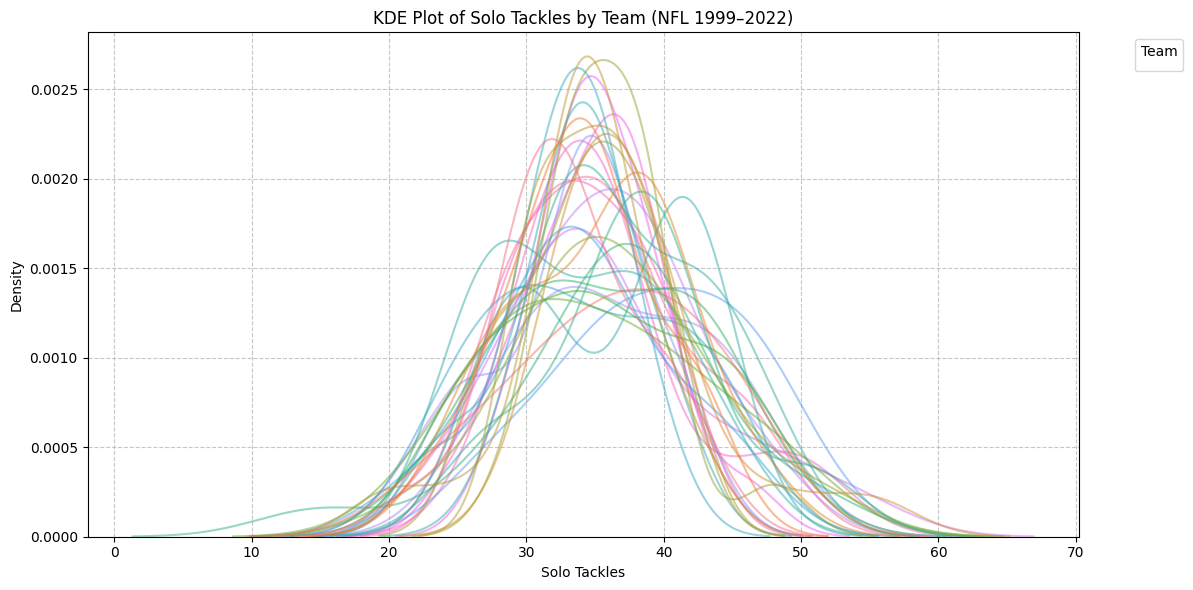

In [54]:
# Assuming df is your DataFrame with 'team' and 'solo_tackle' columns
plt.figure(figsize=(12, 6))

# Use a distinct color palette
colors = sns.color_palette("husl", n_colors=wdf_def_2024['team'].nunique())

# Create KDE plot with transparency
sns.kdeplot(data=wdf_def_2024, x='solo_tackle', hue='team', palette=colors, alpha=0.5)

# Customize title and labels
plt.title('KDE Plot of Solo Tackles by Team (NFL 1999–2022)')
plt.xlabel('Solo Tackles')
plt.ylabel('Density')

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Team')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

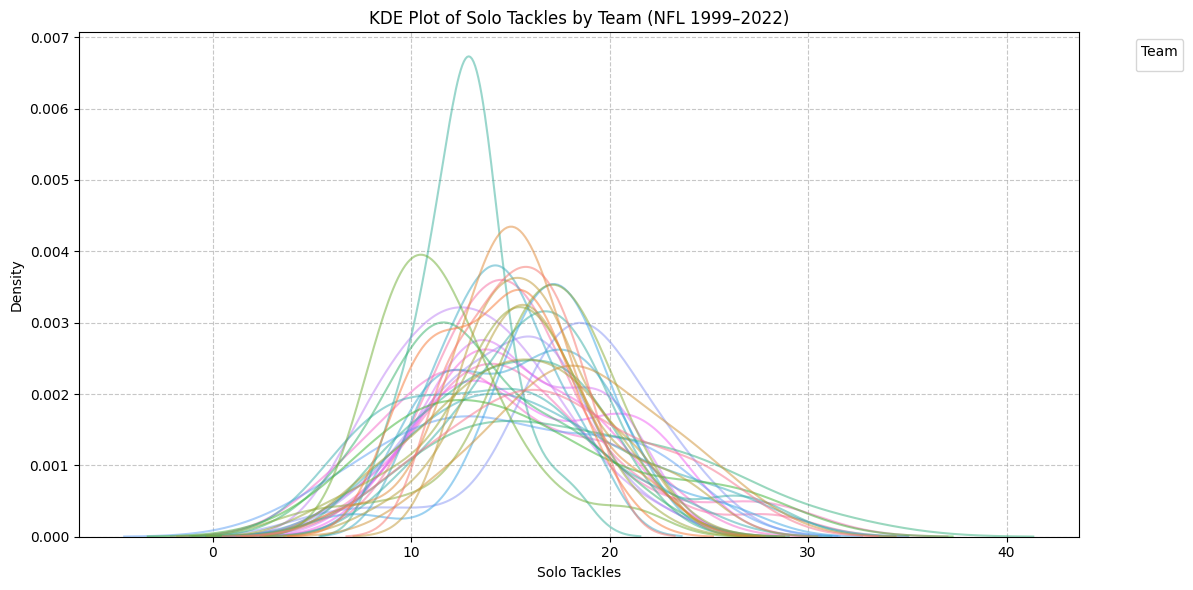

In [55]:
# Assuming df is your DataFrame with 'team' and 'solo_tackle' columns
plt.figure(figsize=(12, 6))

# Use a distinct color palette
colors = sns.color_palette("husl", n_colors=wdf_def_2024['team'].nunique())

# Create KDE plot with transparency
sns.kdeplot(data=wdf_def_2024, x='assist_tackle', hue='team', palette=colors, alpha=0.5)

# Customize title and labels
plt.title('KDE Plot of Solo Tackles by Team (NFL 1999–2022)')
plt.xlabel('Solo Tackles')
plt.ylabel('Density')

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Team')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

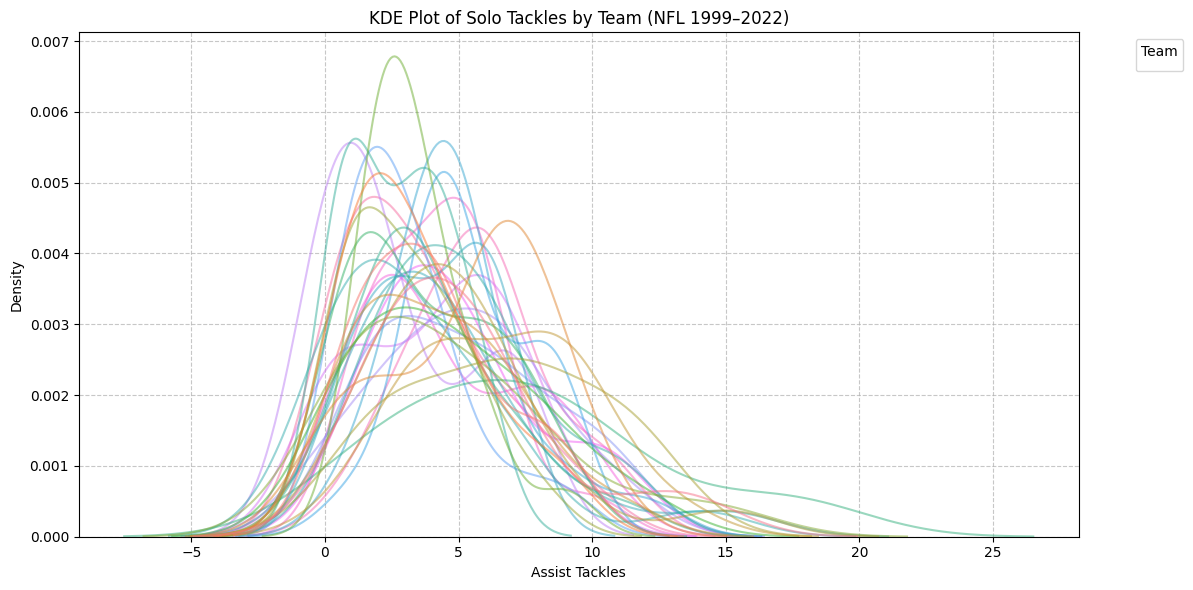

In [57]:
# Assuming df is your DataFrame with 'team' and 'solo_tackle' columns
plt.figure(figsize=(12, 6))

# Use a distinct color palette
colors = sns.color_palette("husl", n_colors=wdf_def_2024['team'].nunique())

# Create KDE plot with transparency
sns.kdeplot(data=wdf_def_2024, x='tackle_with_assist', hue='team', palette=colors, alpha=0.5)

# Customize title and labels
plt.title('KDE Plot of Solo Tackles by Team (NFL 1999–2022)')
plt.xlabel('Assist Tackles')
plt.ylabel('Density')

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Team')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()